<a href="https://colab.research.google.com/github/Atharv-16/GSOC/blob/main/Task-1-Supervised_Image_Classification/image_classification_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and extracting dataset

In [ ]:
!pip install pexpect
!gdown  1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
!unzip '/content/dataset.zip'

In [ ]:
import os
import numpy as np
from PIL import Image

def convert_npy_to_images(npy_folder, jpg_folder):
    # Loop through the class folders in the npy folder
    for class_folder in os.listdir(npy_folder):
        class_npy_folder = os.path.join(npy_folder, class_folder)

        # Ensure it's a directory
        if os.path.isdir(class_npy_folder):
            class_jpg_folder = os.path.join(jpg_folder, class_folder)
            os.makedirs(class_jpg_folder, exist_ok=True)

            # Loop through the numpy files in the class folder
            for file_name in os.listdir(class_npy_folder):
                if file_name.endswith('.npy'):
                    npy_path = os.path.join(class_npy_folder, file_name)
                    img_array = np.load(npy_path).squeeze()  # Squeeze to remove singleton dimensions

                    # Convert to 8-bit unsigned integer (0-255)
                    img_array = (img_array * 255).astype(np.uint8)

                    # Create an Image object from the array
                    img = Image.fromarray(img_array)

                    # Save the image in JPG format
                    jpg_path = os.path.join(class_jpg_folder, os.path.splitext(file_name)[0] + '.jpg')
                    img.save(jpg_path)

# Specify your dataset and output folder paths
dataset_folder = '/content/dataset'
output_folder = '/content/output'

# Convert npy files to images
convert_npy_to_images(os.path.join(dataset_folder, 'train'), os.path.join(output_folder, 'train'))
convert_npy_to_images(os.path.join(dataset_folder, 'val'), os.path.join(output_folder, 'val'))


# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Making data generators

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1 )
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(  )

In [ ]:
train_images=train_generator.flow_from_directory(
    './output/train',
    target_size=(224, 224),
    color_mode='grayscale',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset='training',
    interpolation='nearest',
    # keep_aspect_ratio=False
)

val_images=train_generator.flow_from_directory(
    './output/train',
    target_size=(224, 224),
    color_mode='grayscale',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset='validation',
    interpolation='nearest',
    # keep_aspect_ratio=False
)

test_images=test_generator.flow_from_directory(
    './output/val',
    target_size=(224, 224),
    color_mode='grayscale',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    # keep_aspect_ratio=False
)

Found 27000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 7500 images belonging to 3 classes.


# Visualizing data

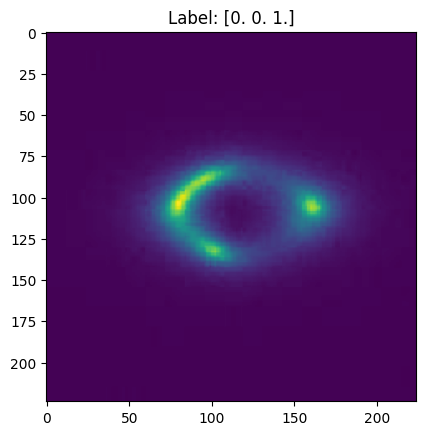

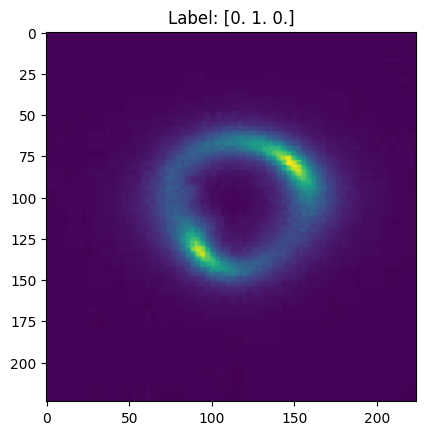

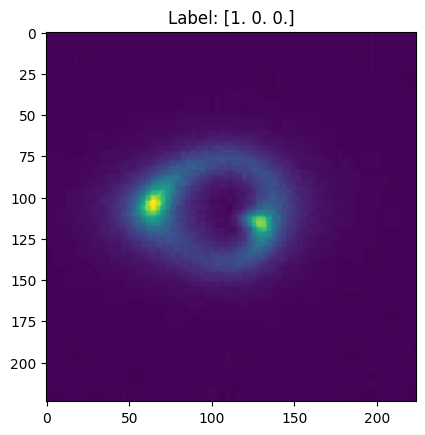

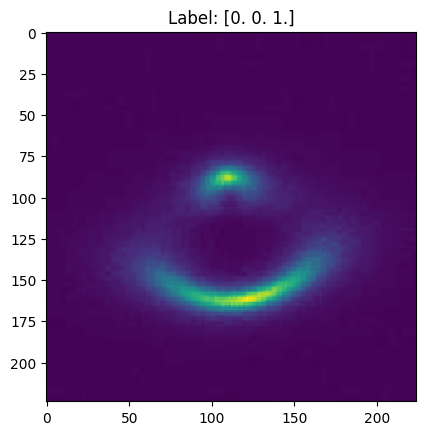

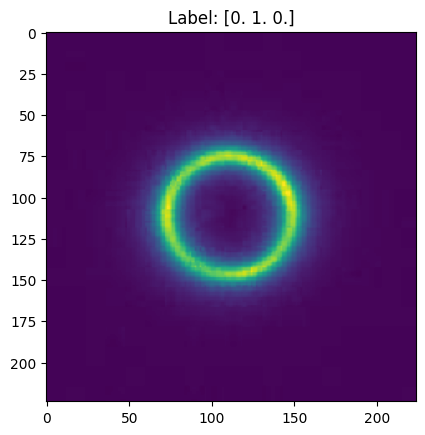

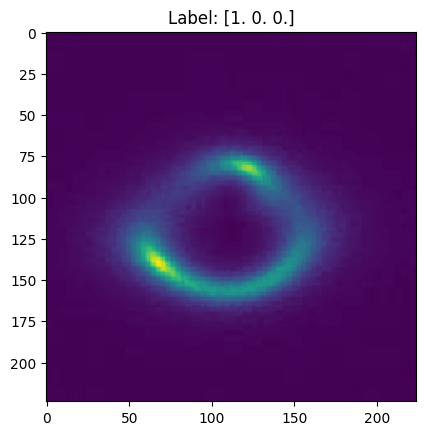

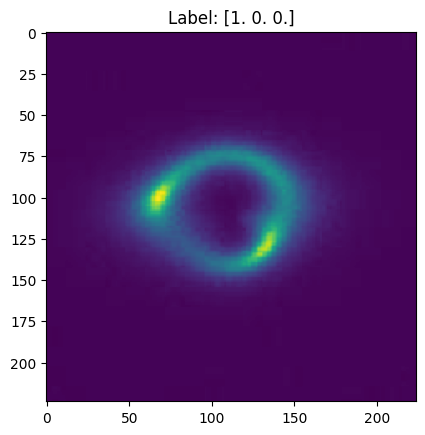

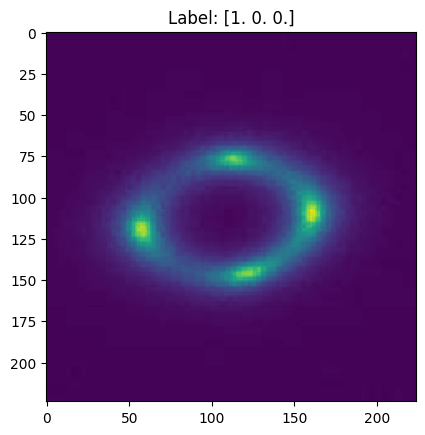

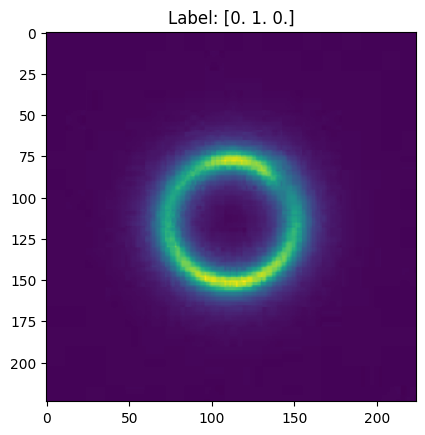

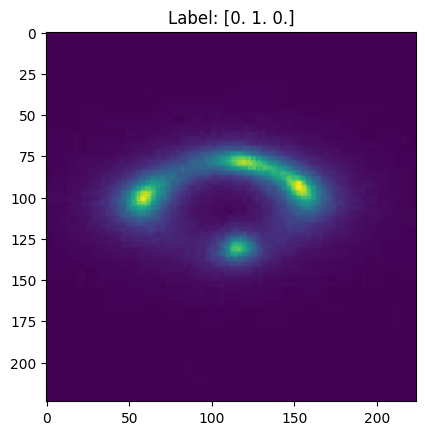

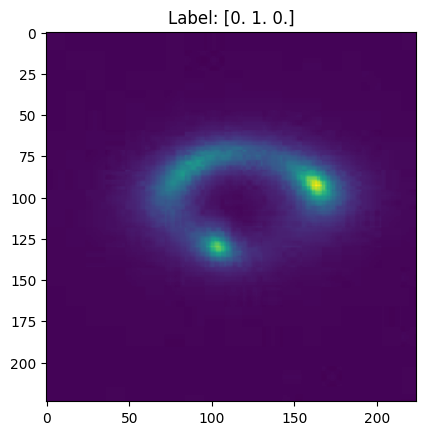

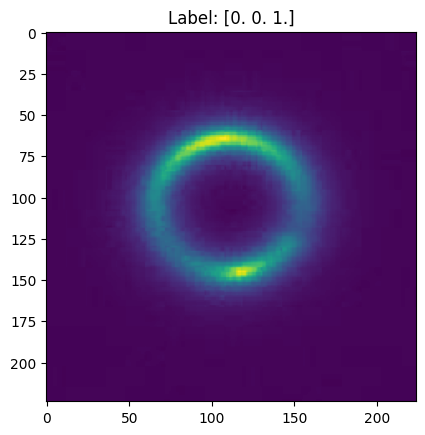

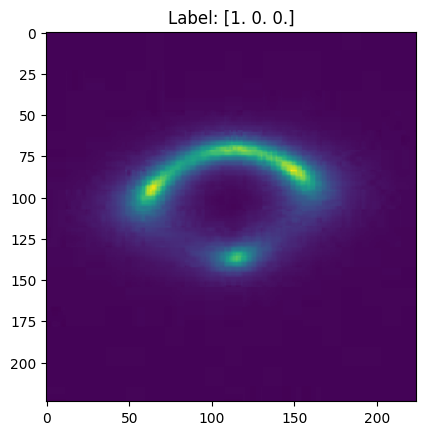

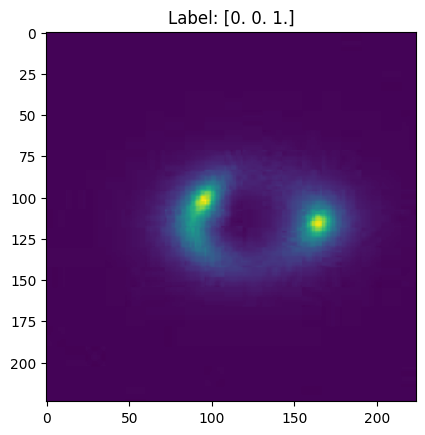

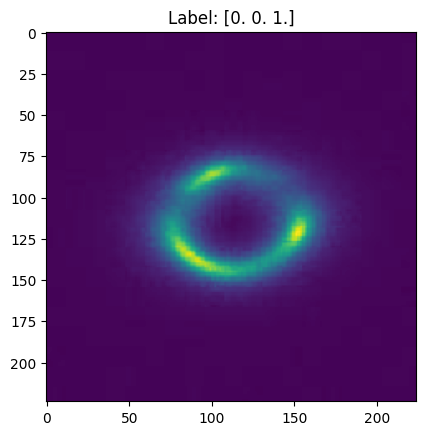

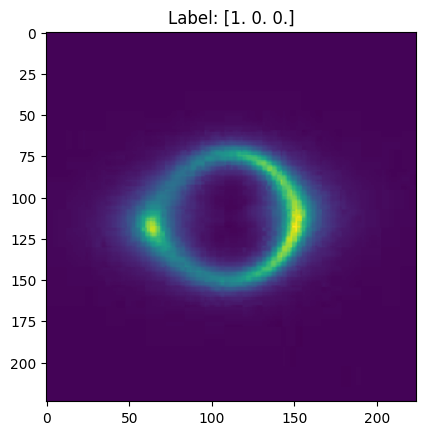

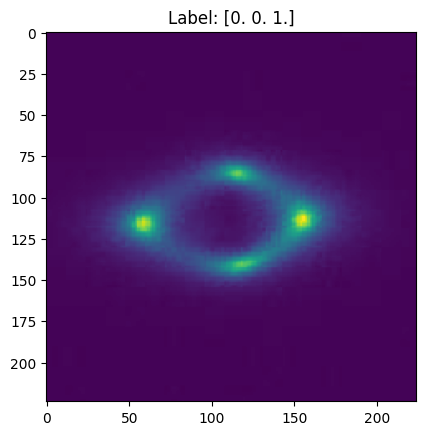

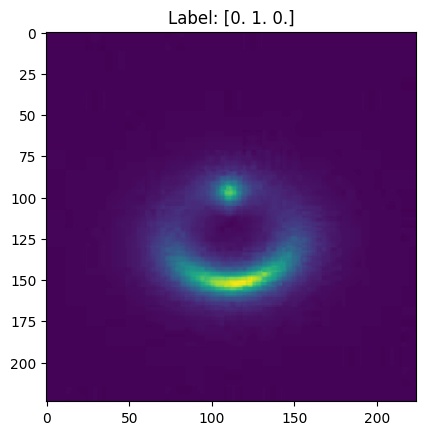

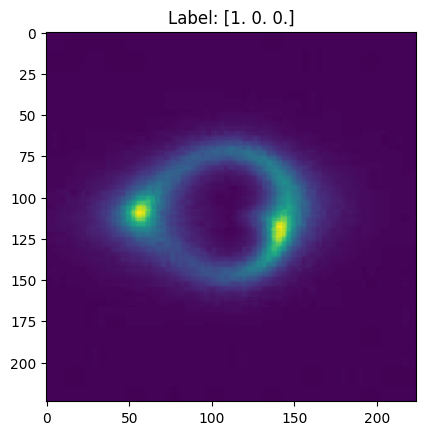

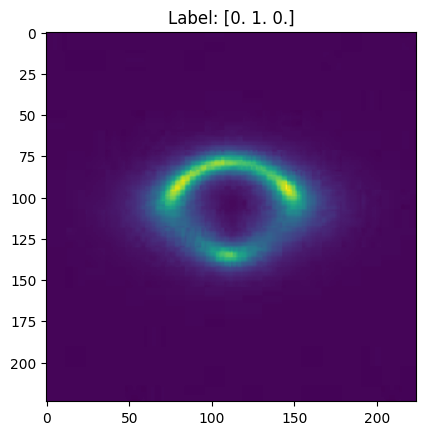

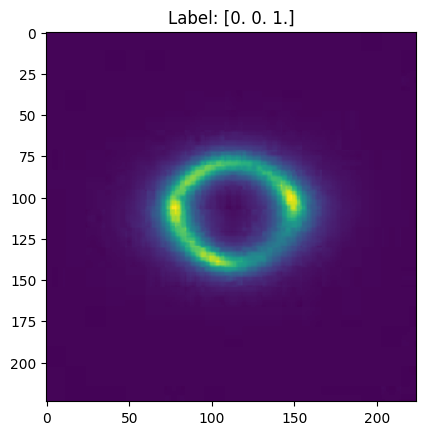

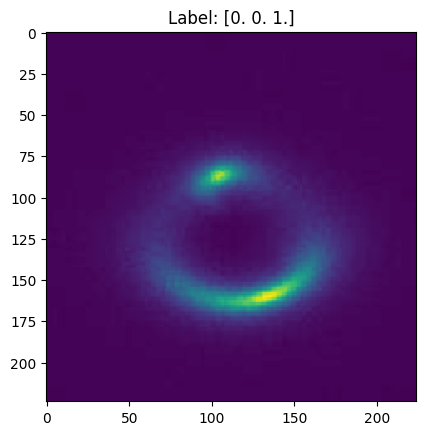

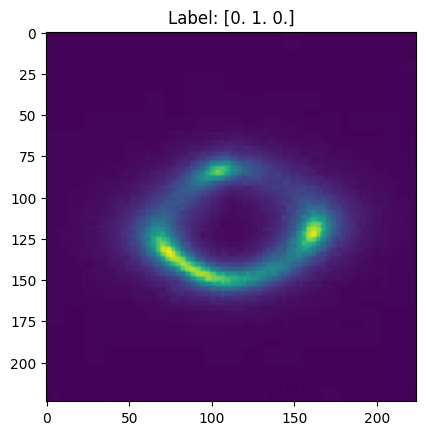

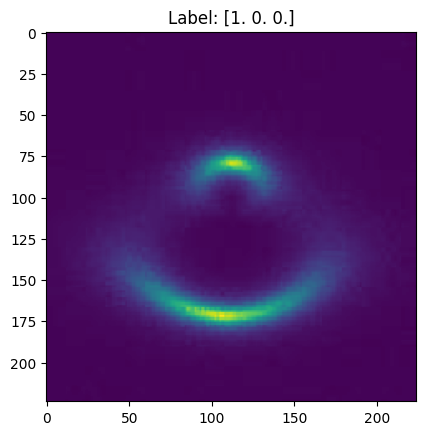

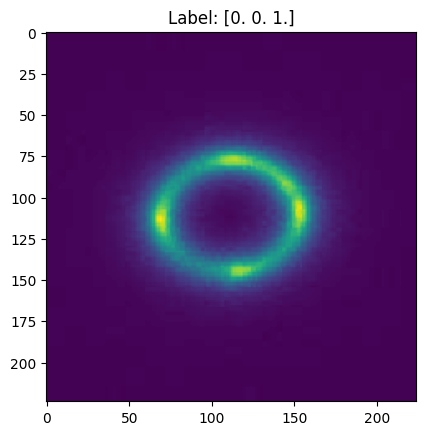

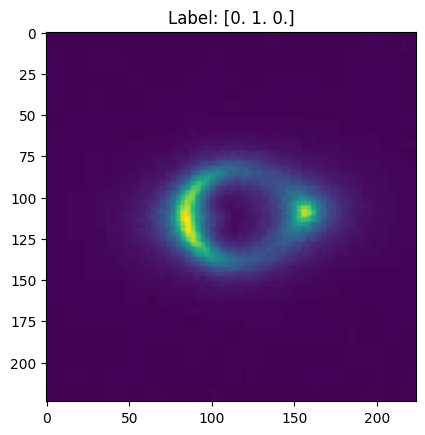

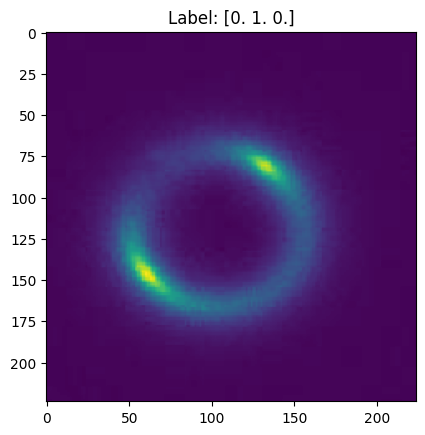

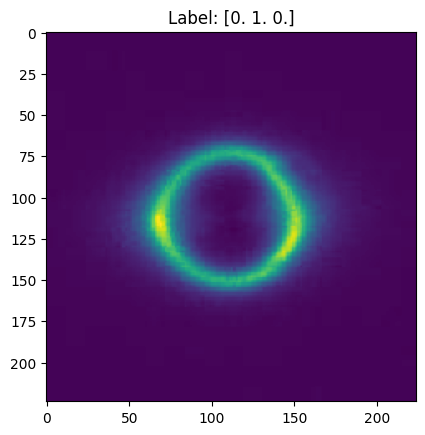

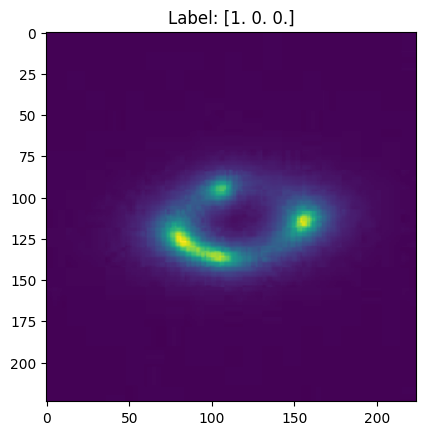

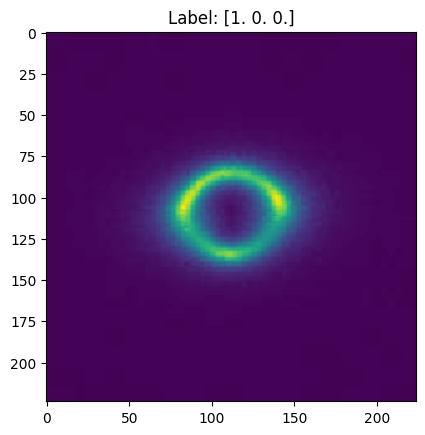

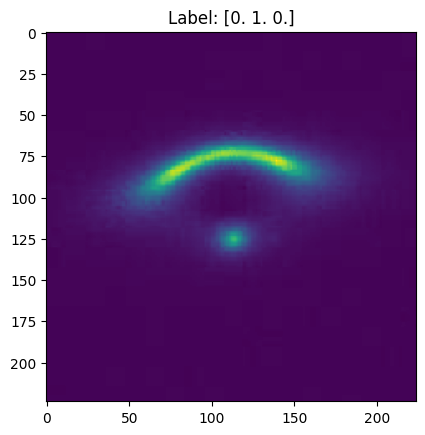

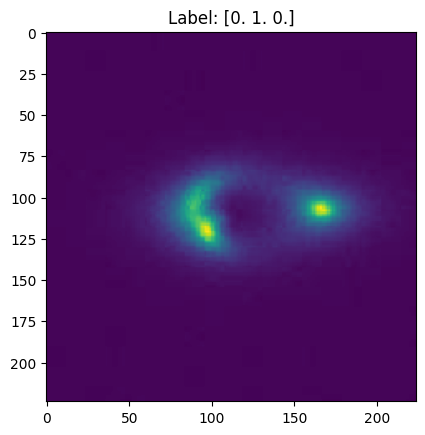

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'train_generator' is your training data generator
images, labels = train_images.next()

# Display the first few images
num_images_to_display = 32
for i in range(num_images_to_display):
    # print((images[i]))
    plt.imshow(images[i]/255)
    plt.title(f"Label: {labels[i]}")
    plt.show()

# Model

In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import BatchNormalization

resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

ipt = layers.Input(shape=(224, 224, 1), name="input")
x = tf.keras.layers.Concatenate()([ipt, ipt, ipt])
x = tf.cast(x, tf.float32)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = resnet_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.35)(x)
out = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=ipt, outputs=out)

# Training

In [ ]:
import numpy as np
import tensorflow as tf

# Set random seed for NumPy
np.random.seed(4332)

# Set random seed for TensorFlow
tf.random.set_seed(4332)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True)
history = model.fit(train_images,validation_data=val_images,epochs=35,
    callbacks=[callbacks])

Epoch 1/35
844/844 [==============================] - 188s 216ms/step - loss: 0.9011 - accuracy: 0.5411 - val_loss: 0.6402 - val_accuracy: 0.7317
Epoch 2/35
844/844 [==============================] - 210s 249ms/step - loss: 0.4569 - accuracy: 0.8229 - val_loss: 0.8775 - val_accuracy: 0.6050
Epoch 3/35
844/844 [==============================] - 239s 283ms/step - loss: 0.3306 - accuracy: 0.8776 - val_loss: 0.3889 - val_accuracy: 0.8473
Epoch 4/35
844/844 [==============================] - 251s 297ms/step - loss: 0.2681 - accuracy: 0.9033 - val_loss: 0.3091 - val_accuracy: 0.8817
Epoch 5/35
844/844 [==============================] - 250s 296ms/step - loss: 0.2178 - accuracy: 0.9216 - val_loss: 0.5531 - val_accuracy: 0.7883
Epoch 6/35
844/844 [==============================] - 262s 310ms/step - loss: 0.1786 - accuracy: 0.9372 - val_loss: 0.4531 - val_accuracy: 0.8747
Epoch 7/35
844/844 [==============================] - 257s 305ms/step - loss: 0.1524 - accuracy: 0.9468 - val_loss: 0.3456 -

# Evaluation

In [ ]:
results = model.evaluate(test_images, verbose=1)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

235/235 [==============================] - 15s 63ms/step - loss: 0.3749 - accuracy: 0.9096
[0.3748854100704193, 0.909600019454956]
Test Accuracy: 90.96%


# Confusion Matrix

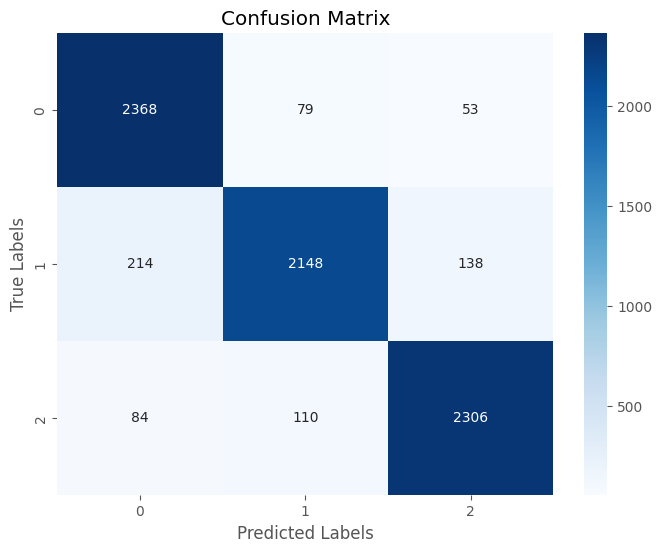

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions using the model and the test generator
predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test generator
true_labels = test_images.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:\n",results)

Classification Report:
 [0.3748854100704193, 0.909600019454956]


In [ ]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,0.552992,0.781467,0.457634,0.827600
1,0.378569,0.856700,1.980609,0.599467
2,0.338882,0.872967,2.025767,0.624000
3,0.305768,0.888600,0.901981,0.683733
4,0.267124,0.902167,0.373066,0.854533
5,0.241687,0.913633,0.516941,0.790133
6,0.231409,0.916200,0.448076,0.820533
7,0.254522,0.910400,1.687867,0.644400
8,0.191364,0.930600,0.253379,0.912533
9,0.185730,0.934533,0.425177,0.843200


In [ ]:
# Convert predicted probabilities to binary labels (0 or 1)
y_pred = np.argmax(predictions, axis=1)
# Use true labels as y_true
y_true = true_labels

# ROC Curve and AUC Scores

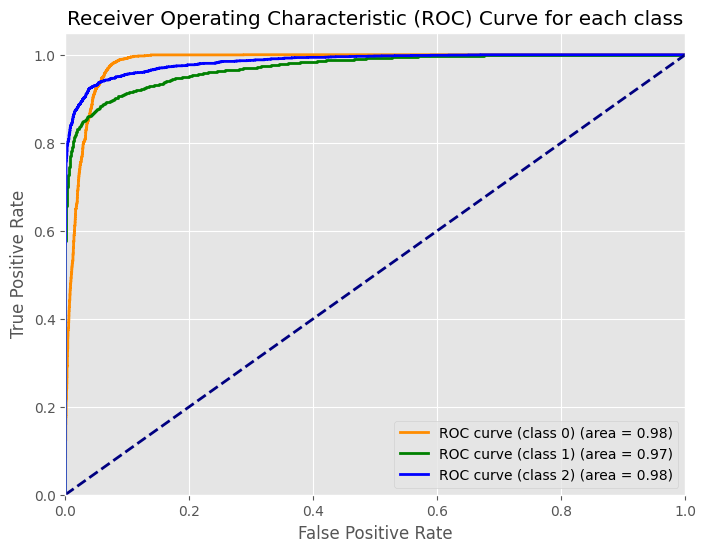

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # num_classes is the number of classes (e.g., 3 in your case)
    fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']  # You can customize the colors as needed
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='ROC curve (class {}) (area = {:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Assuming y_true contains true labels (0, 1, or 2) and predictions contains predicted probabilities for each class
# Compute AUC for each class
auc_scores = []
for i in range(3):
    # Treat class i as the positive class and the rest as the negative class
    y_true_binary = np.where(y_true == i, 1, 0)
    auc_scores.append(roc_auc_score(y_true_binary, predictions[:, i]))

# Compute macro-average AUC
auc_macro = np.mean(auc_scores)

# Compute micro-average AUC
# Convert true labels to a binary matrix representation
y_true_binary = np.eye(3)[y_true]
auc_micro = roc_auc_score(y_true_binary, predictions, average='micro')

print("AUC Scores for Each Class:", auc_scores)
print("Macro-average AUC:", auc_macro)
print("Micro-average AUC:", auc_micro)


AUC Scores for Each Class: [0.9826258, 0.97102376, 0.9845243199999999]
Macro-average AUC: 0.9793912933333333
Micro-average AUC: 0.9822090133333333


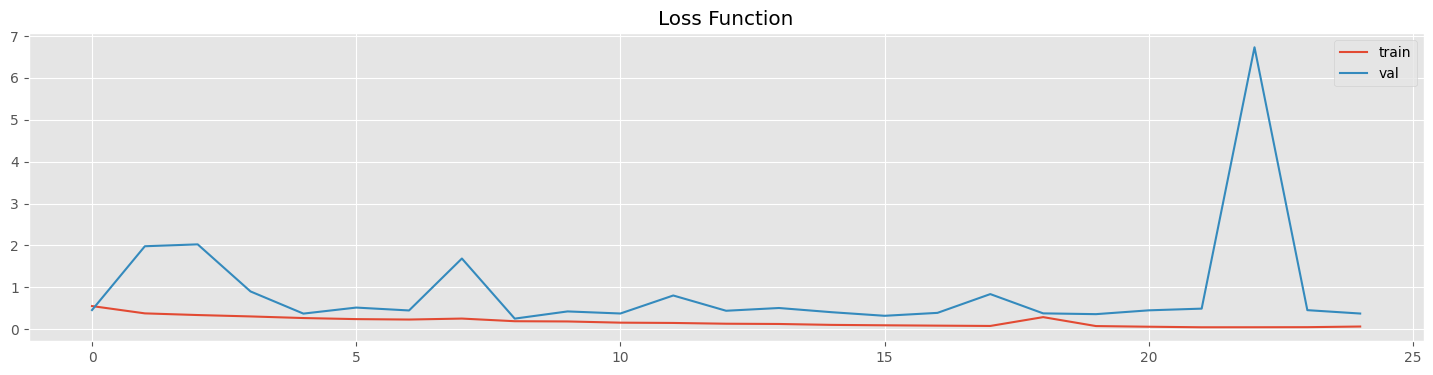

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['loss'], label = 'train')
plt.plot(data_his['val_loss'], label = 'val')
plt.legend()
plt.title('Loss Function')
plt.show()
fig.savefig("Loss Function",dpi=700)

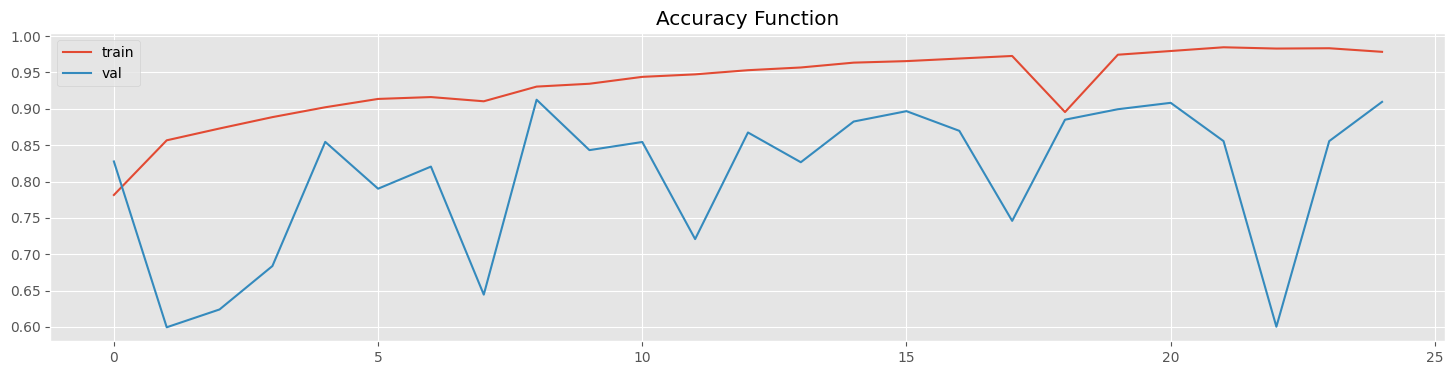

In [ ]:
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['accuracy'], label = 'train')
plt.plot(data_his['val_accuracy'], label = 'val')
plt.legend()
plt.title('Accuracy Function')
plt.show()
fig.savefig("Accuracy Function",dpi=700)

In [ ]:
train_images.class_indices.keys()

dict_keys(['no', 'sphere', 'vort'])

In [ ]:
train_images.class_indices.values()

dict_values([0, 1, 2])

In [ ]:
df=pd.DataFrame({'names':list(train_images.class_indices.keys()),
                 'index':list(train_images.class_indices.values())})

In [ ]:
df.iloc[0]['names']

'no'

In [ ]:
model.save("image_classification_resnet.h5")